In [7]:
import os
import sys

In [8]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
from recpack.preprocessing.filters import MinItemsPerUser, MinUsersPerItem, MinRating, Deduplicate
from recpack.datasets import MovieLens25M

In [11]:
from minipack.scenarios import ProportionalStratifiedStrongGeneralization, StrongGeneralization

In [12]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

## Summary Statistics for MovieLens25M

In [13]:
def import_dataset():
    dataset = MovieLens25M(path='../data/', use_default_filters=False)
    dataset.add_filter(MinRating(4, dataset.RATING_IX))
    dataset.add_filter(MinUsersPerItem(5, dataset.ITEM_IX, dataset.USER_IX))
    dataset.add_filter(MinItemsPerUser(5, dataset.ITEM_IX, dataset.USER_IX))
    dataset.add_filter(Deduplicate(dataset.USER_IX, dataset.ITEM_IX))
    dataset.fetch_dataset()
    return dataset

In [14]:
dataset = import_dataset()
data = dataset.load()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 12411450/12411450 [00:05<00:00, 2285872.27it/s]


In [15]:
data.num_active_users

160770

In [16]:
data.num_interactions

12411450

In [17]:
data.num_active_items

19937

In [18]:
data.num_interactions / (data.num_active_users * data.num_active_items)

0.003872199293795235

### User Statistics (All Data)

In [19]:
data._df.head()

,interactionid,uid,iid,ts
0,0,0,0,1147880044
1,1,0,1,1147868828
2,2,0,2,1147878820
3,3,0,3,1147868495
4,4,0,4,1147868839


In [20]:
interaction_count = data._df.groupby(['uid'])['iid'].count()

In [21]:
type(interaction_count)

pandas.core.series.Series

In [22]:
# 95% Quantile of Interactions
interaction_count.quantile(0.95)

262.0

95% of the user history legnths fall within the range [0, 261]. We create 5 bins between [0, 270] (rounded up for tidiness), which means we need bin widths of 54. Since we perform an 80-20% split for test in and test out data. We increase the bin width from 54 to 67.5 (54/0.8). This ensures that the data to be minimized (test in) has the number of interactions as defined by the bins.

In [23]:
interaction_count.describe()

count    160770.000000
mean         77.200037
std         107.790676
min           5.000000
25%          21.000000
50%          41.000000
75%          90.000000
max        3211.000000
Name: iid, dtype: float64

<Axes: xlabel='iid'>

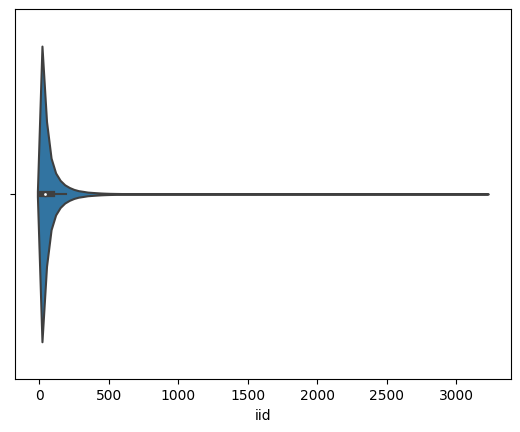

In [24]:
sns.violinplot(x=interaction_count)

### User Stratification (All Data)

/Users/jens/.pyenv/versions/3.11.8/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


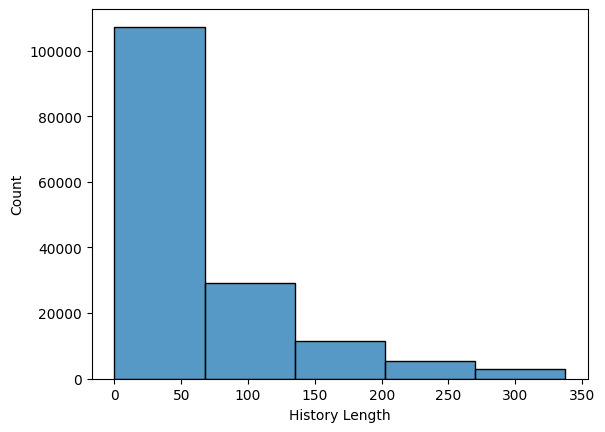

In [25]:
ax = sns.histplot(data=interaction_count, binwidth=67.5, binrange=[0, 337.5])
ax.set_ylabel("Count")
ax.set_xlabel("History Length")
plt.show()

In [26]:
# Calculating the number of users in each bin
bin_range = np.arange(0, 338, 67.5)  

In [27]:
bin_range

array([  0. ,  67.5, 135. , 202.5, 270. , 337.5])

In [28]:
# Calculating the number of users in each bin using pd.cut
users_per_bin = pd.cut(interaction_count, bins=bin_range, right=False)
users_per_bin = users_per_bin.value_counts().sort_index()

# Adjusting labels for clarity since the upper limit is exclusive
bin_labels = [f"[{bin_range[i]}, {bin_range[i+1]})" for i in range(len(bin_range)-1)]
users_per_bin.index = bin_labels

# Creating an integer index
# users_per_bin.index = range(len(users_per_bin))

print(users_per_bin)

[0.0, 67.5)       107271
[67.5, 135.0)      29033
[135.0, 202.5)     11470
[202.5, 270.0)      5394
[270.0, 337.5)      2893
Name: count, dtype: int64


In [29]:
# Generate bin indices and bin ranges
bin_indices = list(range(len(users_per_bin)))
bin_ranges = [f"[{bin_range[i]}, {bin_range[i+1]})" for i in range(len(bin_range)-1)]

# Calculate the total number of elements
total_count = users_per_bin.sum()

# Calculate the fraction of each bin compared to the whole
bin_fractions = users_per_bin / total_count

# Create a dictionary to hold the bin indices, counts, fractions, and ranges
bin_dict = {
    'bindex': bin_indices,
    'bin_range': bin_ranges,
    'bin_fraction': bin_fractions.values
}

# Convert dictionary to DataFrame (optional, if needed for merging later)
bin_df = pd.DataFrame(bin_dict)

print(bin_df)

   bindex       bin_range  bin_fraction
0       0     [0.0, 67.5)      0.687366
1       1   [67.5, 135.0)      0.186036
2       2  [135.0, 202.5)      0.073497
3       3  [202.5, 270.0)      0.034563
4       4  [270.0, 337.5)      0.018538


### Scenario

In [30]:
scenario = ProportionalStratifiedStrongGeneralization(num_users_test=10000, num_users_val=40000, num_users_est=1000, bin_width=67.5, bin_range=[0, 337.5], validation=True, estimation=True, seed=42)
scenario.split(data)

6873it [00:00, 8887.25it/s]
1860it [00:00, 8688.71it/s]
734it [00:00, 8449.41it/s]
345it [00:00, 8030.38it/s]
188it [00:00, 7609.82it/s]
40000it [00:04, 8791.69it/s]
687it [00:00, 8979.45it/s]
185it [00:00, 8285.69it/s]
73it [00:00, 7591.78it/s]
33it [00:00, 6595.13it/s]
22it [00:00, 5580.91it/s]


In [31]:
full_train = scenario.full_training_data
val_train = scenario.validation_training_data
val_in = scenario.validation_data_in
val_out = scenario.validation_data_out
test_in = scenario.test_data_in
test_out = scenario.test_data_out

In [32]:
test_in.num_active_users

10000

In [33]:
test_in.num_interactions

514250

In [34]:
test_avg_interactions = test_in.num_interactions / test_in.num_active_users
test_avg_interactions

51.425

In [35]:
val_in.num_active_users

40000

In [36]:
data.num_interactions

12411450

### User Stratification (Test Data)

In [37]:
[test_data_bin.num_active_users for test_data_bin in scenario.test_data_in_bins]

[6873, 1860, 734, 345, 188]

In [38]:
[test_data_bin.num_interactions / test_data_bin.num_active_users for test_data_bin in scenario.test_data_in_bins]

[23.99854503128183,
 77.02258064516128,
 131.80926430517712,
 185.99710144927536,
 240.04787234042553]